### Business Scenario

RestoreMasters is a car restoration company based in New York, USA. Within short span of time, this company has become renowned for restoring vintage cars. Their team takes great pride in each of their projects, no matter how big or small. They offer paint jobs, frame build-ups, engine restoration, body work etc. They restore cars of various origins including USA, Europe and Asia. 

The management wants to expand their business by increasing the capacity of the number of cars that can be restored. They want to generate greater revenue for the company through cost cutting and providing a data driven approach to their current process. They feel that the insights from existing data will help them in making data-driven decisions and also automate some of the key tasks in the process.

<hr style="border:2px solid gray">

#**STEP: 0/4** - Run the following lines of code and move to Step 1. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline as sklearn_pipeline
from sklearn.metrics import classification_report

from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
%%capture
!pip install category_encoders==2.*
!pip install pdpbox
!pip install shap

from category_encoders import OrdinalEncoder
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap

In [ ]:
#Update the DATA_PATH variable

import sys

if 'google.colab' in sys.modules:
  # If you're on Colab:
  DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/ds_code_along_unit_2/main/data/restoremasters/'
else:
  # If you're working locally:
  DATA_PATH = '..../data/'

In [ ]:
# importing the dataset to Pandas DataFrame: cars_df
cars_df=pd.read_csv(DATA_PATH +'auto_mpg.csv')

In [ ]:
# display the data in DataFrame: cars_df
cars_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [ ]:
# Replacing missing values with mean horsepower of cars with similar cylinders and model_year
cars_df['horsepower'] = cars_df.groupby(['cylinders', 'model_year'])['horsepower'].apply(lambda x: x.fillna(x.mean()))

In [ ]:
# checking for missing values in columns of the DataFrame: cars_df
cars_df.isna().any()

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model_year      False
origin          False
name            False
dtype: bool

In [ ]:
# get the duplicate records in the DataFrame: cars_df
cars_df[cars_df.duplicated()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name


In [ ]:
# dropping the duplicate records in the DataFrame: cars_df
cars_df.drop_duplicates(inplace=True)
cars_df.duplicated().sum()

0

In [ ]:
# finding the upper and lower limit of horespower and acceleration columns

def find_outlier_limits(col_name):
    Q1,Q3=cars_df[col_name].quantile([.25,.75])
    IQR=Q3-Q1
    low=Q1-(1.5* IQR)
    high=Q3+(1.5* IQR)
    return (high,low)

high_hp,low_hp=find_outlier_limits('horsepower')
print('Horsepower: ','upper limit: ',high_hp,' lower limit: ',low_hp)
high_acc,low_acc=find_outlier_limits('acceleration')
print('Acceleration: ','upper limit: ',high_acc,' lower limit:',low_acc)

# Replacing outlier values in horespower and acceleration columns with respective 
# upper and lower limits

cars_df.loc[cars_df['horsepower']>high_hp,'horsepower']=high_hp
cars_df.loc[cars_df['acceleration']>high_acc,'acceleration']=high_acc
cars_df.loc[cars_df['acceleration']<low_acc,'acceleration']=low_acc

Horsepower:  upper limit:  200.0  lower limit:  0.0
Acceleration:  upper limit:  22.2  lower limit: 8.8


In [ ]:
# Extracting the company name from the name column
cars_df['company']=cars_df['name'].apply(lambda x:x.split()[0])
cars_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,company
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu,chevrolet
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320,buick
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite,plymouth
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst,amc
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino,ford


In [ ]:
# based on mpg and cylinders, creating a new column - car_type (hatchback, sedan, SUV, sports)

cars_df.loc[(cars_df['cylinders']==3),'car_type']='Hatchback'
cars_df.loc[(cars_df['cylinders']==4) & (cars_df['mpg']>=30),'car_type']='Hatchback'
cars_df.loc[(cars_df['cylinders']==5),'car_type']='Sedan'
cars_df.loc[(cars_df['cylinders']==4) & (cars_df['mpg']<30),'car_type']='Sedan'
cars_df.loc[(cars_df['cylinders']==6),'car_type']='SUV'
cars_df.loc[(cars_df['cylinders']==8),'car_type']='Sports'

In [ ]:
# drop the ```cylinders``` and ```name``` columns

cars_df.drop(columns=['cylinders','name'],inplace=True)

In [ ]:
cars_df.head()

,mpg,displacement,horsepower,weight,acceleration,model_year,origin,company,car_type
0,18.0,307.0,130.0,3504,12.0,70,usa,chevrolet,Sports
1,15.0,350.0,165.0,3693,11.5,70,usa,buick,Sports
2,18.0,318.0,150.0,3436,11.0,70,usa,plymouth,Sports
3,16.0,304.0,150.0,3433,12.0,70,usa,amc,Sports
4,17.0,302.0,140.0,3449,10.5,70,usa,ford,Sports


In [ ]:
# Split the data into Feature Matrix and Target Vector
target = 'car_type'
y = cars_df[target]
X = cars_df.drop(columns=[target])

# Split data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# Ordinal Encode categorical values (we will not be using pipelines today)
oe = OrdinalEncoder()
oe.fit(X_train)
XT_train = oe.transform(X_train)
XT_test = oe.transform(X_test)

In [ ]:
# Build a Random Forest Classifier Model
model_rf = RandomForestClassifier(random_state=42,n_jobs=-1)
model_rf.fit(XT_train, y_train);

<hr style="border:2px solid gray">

---



#**STEP: 1/4** - Evaluate and interpret model performance


In [ ]:
# check accuracy

print('Test Accuracy:', accuracy_score(y_test, model_rf.predict(XT_test)))

Test Accuracy: 0.9625


In [ ]:
# build classification report

print(classification_report(y_test, model_rf.predict(XT_test)))

              precision    recall  f1-score   support

   Hatchback       1.00      1.00      1.00        14
         SUV       0.87      0.93      0.90        14
       Sedan       0.97      1.00      0.98        28
      Sports       1.00      0.92      0.96        24

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



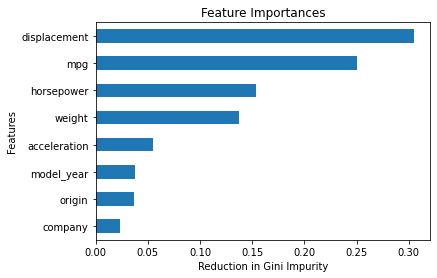

In [ ]:
# Plot the top ten feature importances

importances = model_rf.feature_importances_
features = oe.get_feature_names()
feat_imp = pd.Series(importances, index=features).sort_values(key=abs)
feat_imp.tail(20).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity')
plt.ylabel('Features')
plt.title('Feature Importances');

<hr style="border:2px solid gray">

#**STEP: 2/4** - Permutation Importances


In [ ]:
# calculate permutation importances

perm_imp = permutation_importance(model_rf,XT_test,y_test,random_state=42) # default n_repeats=5

In [ ]:
perm_imp

{'importances_mean': array([ 0.19  ,  0.4275,  0.01  , -0.0075, -0.0025,  0.    ,  0.    ,
         0.    ]),
 'importances_std': array([0.03201562, 0.04769696, 0.01658312, 0.00612372, 0.00935414,
        0.        , 0.        , 0.        ]),
 'importances': array([[ 0.2375,  0.15  ,  0.1875,  0.1625,  0.2125],
        [ 0.375 ,  0.475 ,  0.425 ,  0.375 ,  0.4875],
        [ 0.    , -0.0125,  0.0375,  0.0125,  0.0125],
        [ 0.    , -0.0125, -0.0125,  0.    , -0.0125],
        [-0.0125, -0.0125,  0.    ,  0.    ,  0.0125],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ]])}

In [ ]:
#create a dataframe for easy interpretation

data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}

df_perm = pd.DataFrame(data_perm, index=XT_test.columns).sort_values('imp_mean')

In [ ]:
df_perm

,imp_mean,imp_std
weight,-0.0075,0.006124
acceleration,-0.0025,0.009354
model_year,0.0000,0.000000
origin,0.0000,0.000000
company,0.0000,0.000000
horsepower,0.0100,0.016583
mpg,0.1900,0.032016
displacement,0.4275,0.047697


<hr style="border:2px solid gray">

#**STEP: 3/4** - PDP Interact Plot


In [ ]:
#select two features
two_selected_features = ['mpg','displacement']

In [ ]:
# instantiate pdp_interact class

interact = pdp_interact(
    model_rf,
    dataset=XT_test,
    model_features = XT_test.columns,
    features=two_selected_features
)

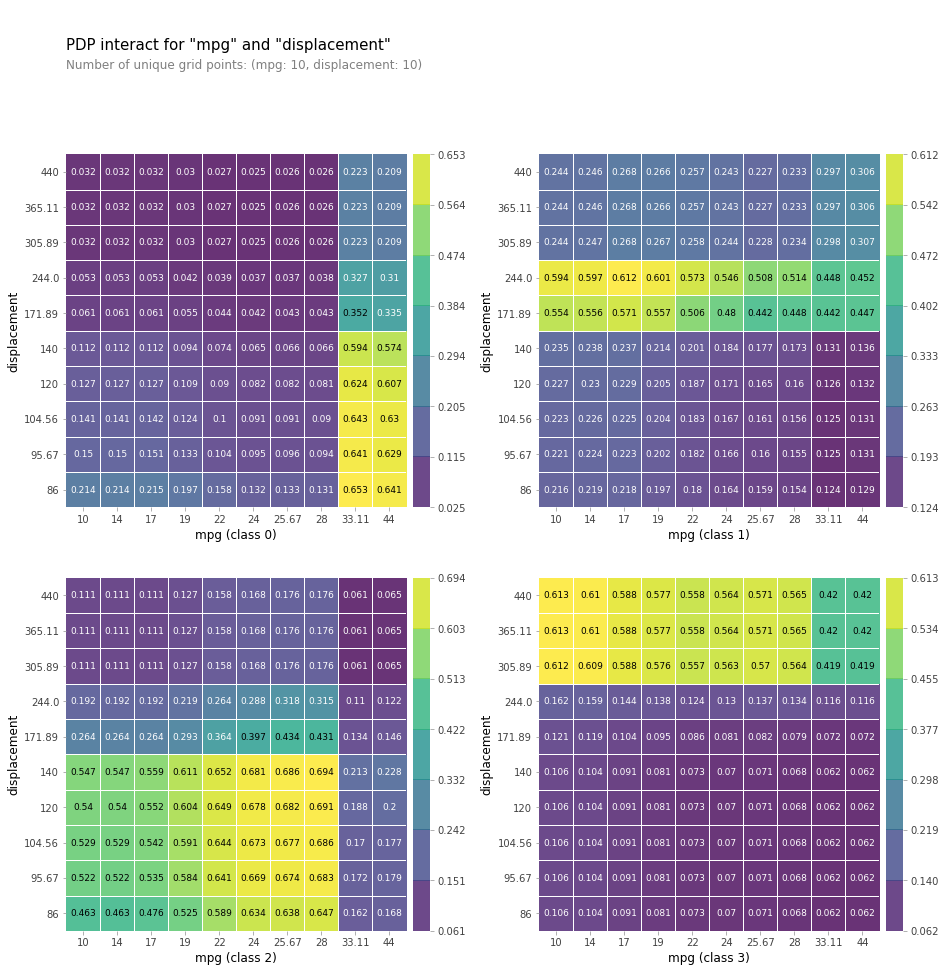

In [ ]:
# Plot PDP interact plot

pdp_interact_plot(interact, plot_type='grid', feature_names = two_selected_features);

<hr style="border:2px solid gray">

#**STEP: 4/4** - Shapley Plot

In [ ]:
# select sample

sample_row = XT_test.head(1)

In [ ]:
# final model prediction for this sample

model_rf.predict(XT_test)[0]

'Hatchback'

In [ ]:
# Create an instance of TreeExplainer
explainer = shap.TreeExplainer(model_rf)  # does not like pipelines

#get shap values
shap_values = explainer.shap_values(sample_row)

shap.initjs() #initialization of java script.

# force plot
shap.force_plot(
    base_value = explainer.expected_value[0],
    shap_values=shap_values[0],
    features = sample_row
)